## community detection - BOSTON
master notebook

In [56]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product

#import networkx.algorithms.community as nx_comm

%matplotlib inline

In [57]:
# ez tolti be az octave cell magicet
%load_ext oct2py.ipython

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


### Graph prep

In [58]:
# data IN
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz") ## A MOBILITY HÁLÓBÓL SZÁMOLOK POSITION-T, AZÉRT KELL!

follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)

### CHOOSE A METROPOLITAN AREA HERE

In [59]:
city = "Boston" # here
city_code = cbsacode[cbsacode.short_name == city].iloc[0].cbsacode

In [60]:
# BOSTON filter
mobility = mobility[mobility["cbsacode"] == city_code]
follow_hh = follow_hh[follow_hh["cbsacode"] == city_code]

In [61]:
# create graphs

# create empty graphs
g_fol_hh = nx.Graph() # follow home-home graph - weights are counts
g_fol_hh_lw = nx.Graph() # graphs with log edge weights - new_weight=log(1+weight) 
g_fol_hh_Nw = nx.Graph() # graphs with NO WEIGHTS


# fill in the networks with data
follow_hh['w_edges'] = list(zip(follow_hh.tract_home,follow_hh.tract_home_1,follow_hh.cnt))
g_fol_hh.add_weighted_edges_from(follow_hh["w_edges"], weight='cnt')

## graph with log weights
follow_hh['cnt_2']=np.log(1+follow_hh['cnt'])
follow_hh['w_edges_2']=list(zip(follow_hh.tract_home,follow_hh.tract_home_1,follow_hh.cnt_2))
g_fol_hh_lw.add_weighted_edges_from(follow_hh["w_edges_2"], weight='cnt_2')

## graph with NO WEIGHTS 
follow_hh['edges'] = list(zip(follow_hh.tract_home,follow_hh.tract_home_1))
g_fol_hh_Nw.add_edges_from(follow_hh['edges'])

In [62]:
# remove self loops
g_fol_hh.remove_edges_from(nx.selfloop_edges(g_fol_hh))
g_fol_hh_lw.remove_edges_from(nx.selfloop_edges(g_fol_hh_lw))
g_fol_hh_Nw.remove_edges_from(nx.selfloop_edges(g_fol_hh_Nw))

In [63]:
# choose a graph on which community detection will be calculated
G = g_fol_hh

### geodata prep

In [64]:
# census data IN
census = pd.read_csv("../data/censusdata_top50_2012.csv")
census_2 = pd.read_csv("../data/censusdata_top50_2017.csv")

In [65]:
# create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census['geoid'] = census.apply(create_geoid,axis=1)
census_2['geoid'] = census_2.apply(create_geoid,axis=1)

In [66]:
# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

In [67]:
tract_geoms['centroid'] = tract_geoms['geometry'].centroid

In [68]:
# derékszögű koordináták
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [69]:
#filter geodata for the metropolitan area "city"
b_cbsacode = cbsacode[cbsacode["short_name"] == city]
boston_tracts = pd.merge(tract_geoms, b_cbsacode, left_on='full_geoid', right_on='geoid') # how="left" - EZ ROSSZ VOLT
boston_tracts = boston_tracts.drop(columns='full_geoid')

In [70]:
# MERGE edgelist with coordinates (tract boundaries and centroids)
mobility = pd.merge(mobility,boston_tracts[['geometry','geoid','centroid']],left_on='tract_home', right_on='geoid',how='left') # on home
mobility = mobility.drop(columns='geoid')
mobility = mobility.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

mobility = pd.merge(mobility,boston_tracts[['geometry','geoid','centroid']],left_on='tract_work', right_on='geoid',how='left') # on work
mobility = mobility.drop(columns='geoid')
mobility = mobility.rename(columns={"centroid": "centroid_work", "geometry": "polygon_work"})

follow_hh = pd.merge(follow_hh, boston_tracts[['geometry','geoid','centroid']], left_on='tract_home', right_on='geoid', how='left')
follow_hh = follow_hh.drop(columns='geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

follow_hh = pd.merge(follow_hh, boston_tracts[['geometry','geoid','centroid']], left_on='tract_home_1', right_on='geoid',how='left')
follow_hh = follow_hh.drop(columns='geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home_1", "geometry": "polygon_home_1"})

### community detection 1 - using Expert's code

In [71]:
from scipy.spatial.distance import pdist, squareform

In [72]:
coords = np.array([tract_center_dict[n] for n in g_fol_hh.nodes()])

d = pdist(coords)
D = squareform(pdist(coords))

max_dist = np.amax(D)

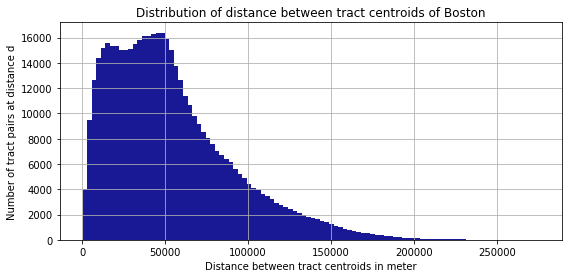

In [73]:
# distance on histogram
# méterben

f = plt.figure(figsize=(9,4))
plt.subplot(111)
plt.hist(d, bins=100, color='darkblue', alpha=0.9) # cumulative=True , 
plt.title('Distribution of distance between tract centroids of Boston')
plt.xlabel('Distance between tract centroids in meter')
plt.ylabel('Number of tract pairs at distance d')
plt.grid()

In [74]:
# adjacency matrix
A = nx.adjacency_matrix(G)

In [75]:
# importance - number of users
tract_outdeg_mob = mobility.groupby('tract_home')[['cnt']].sum()

follow_hh = follow_hh.merge(tract_outdeg_mob, left_on='tract_home', right_index=True)

N = np.matrix([tract_outdeg_mob.loc[k].iloc[0] for k in g_fol_hh.nodes()]).T
# modify N
# N = np.log(N+1)
# N=np.ones((983,983))

In [76]:
# binsize
b = max_dist/99 # number of bins = 100

In [77]:
# tract position dictionary for drawings - position is the tract centroid
pos = dict(zip(mobility.tract_home, mobility.centroid_home.map(lambda p: p.coords[0]))) 
pos.update(dict(zip(mobility.tract_work, mobility.centroid_work.map(lambda p: p.coords[0]))))

In [78]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,nDfn,S,Q,n_it,N 

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [ModularitySpa,ModularityGN,DeterrenceFct,normaDeterrence]=ModularitySpaGN(Flow,Dist,N,binsize)

    % Flow: Adjacency matrix
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    number=size(Flow,1); %number of nodes in the system

    nbox=100; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    normaDeterrence=zeros(nbox,1);

    matrixdistance=zeros(number,number);
    nullmodelGN=zeros(number,number);
    nullmodelSpa=zeros(number,number);

    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix ????????? A_ij/(N_i*N_j)

    %We first calculate the correlations as a function of distance

    % minden csucsparra futok
    for i=1:number
        for ii=1:number
        
        % megnezem a ket csucs tavolsagat, megnezem, h melyik binbe esnek, ez lesz a dist
        % convert distances in binsize's units
        dist=1+ceil(Dist(i,ii)/binsize); %????? miert nem floor
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix(i,ii); % A_ij/(N_i*N_j) [i,ii] -edik eleme....
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1); % sum A_ij
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1); % sum N_i*N_j
        end 
    end

    % normalisation of the deterrence function
      for i=1:nbox % ezt kommentáltam ki
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model P_ij/(N_i*N_j)
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn,nDfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Ms); % Ms spatial-t

# Itt tartok

In [654]:
# CSAK EGYSZER KELL LEFUTTATNI
#S_df = pd.DataFrame()
#S_df[len(S_df.columns)] = S.T[0]

In [205]:
S_df['geoid']=g_fol_hh.nodes() ## KERDES JO???
S_df = S_df.set_index('geoid')
#S_df.to_csv('consenzus.csv')

# Using consensus clustering

In [82]:
# consensus_clustering notebook

iters = pd.read_csv("../data/consensus.csv")

geoid_pairs = list(product(list(iters.geoid), list(iters.geoid)))

consen_df = pd.DataFrame(geoid_pairs, columns=['geoid_1','geoid_2'])

# remove selfloops
consen_df = consen_df[consen_df.geoid_1!=consen_df.geoid_2]

iters = iters.set_index('geoid')

iters['clusts'] = iters.values.tolist()

consen_df = pd.merge(consen_df, iters['clusts'], left_on = 'geoid_1', right_on = 'geoid')
consen_df = pd.merge(consen_df, iters['clusts'], left_on = 'geoid_2', right_on = 'geoid')

consen_df = consen_df.rename(columns = {'clusts_x': 'clusts_1', 'clusts_y': 'clusts_2'})

def same(row):
    return np.array(np.equal(row['clusts_1'], row['clusts_2'])).astype(int).sum()

# how many times do the two tracts (geoid_1 and geoid_2) clustered to the same community?
# --> weights of graf on which clustering gives the consensus clustering
consen_df['w'] = consen_df.apply(lambda row: same(row), axis=1)

# graph for consensus clustering
g_cons = nx.Graph() 
consen_df['w_edges'] = list(zip(consen_df.geoid_1,consen_df.geoid_2,consen_df.w))
g_cons.add_weighted_edges_from(consen_df["w_edges"], weight='w')

s_louv = community_louvain.best_partition(g_cons, weight='w')

# SA = np.array([np.array(s_louv[n]) for n in g_fol_hh.nodes()])
S = np.array([np.array([s_louv[n]]) for n in g_fol_hh.nodes()])

In [207]:
S = S + 1 #### ONLY FOR CONSENSUS CLUSTERING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! + 1

In [208]:
# type(SA[0][0])
# type(S[0][0])
# np.array(s_louv['14000US25021419400'])
# arr = SA.astype('nump.ndarray')

In [209]:
#convert list elements into numpy ndarray

In [210]:
hist_d, bin_edges_d = np.histogram(d,bins=99)

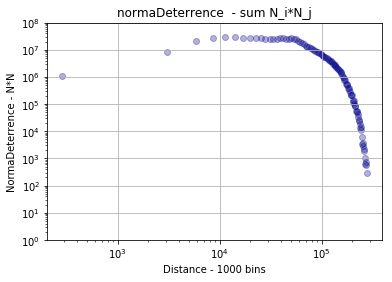

In [211]:
mask = ((Dfn.T[0]/nDfn.T[0])>0.00004)&(bin_edges_d>150000)
plt.scatter(x = bin_edges_d, y = nDfn, c='DarkBlue', alpha=0.3)
plt.scatter(x = bin_edges_d[mask], y = nDfn[mask], c='red', alpha=0.3)
plt.title('normaDeterrence  - sum N_i*N_j')
plt.xlabel('Distance - 1000 bins')
plt.ylabel('NormaDeterrence - N*N')
plt.loglog()
plt.ylim(1,1e8)
plt.grid()

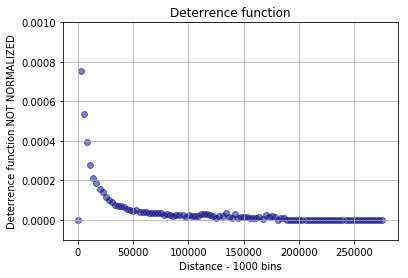

In [212]:
mask = ((Dfn.T[0]/nDfn.T[0])>0.00004)&(bin_edges_d>150000)
plt.scatter(x = bin_edges_d, y = Dfn, c='DarkBlue', alpha=0.5)
plt.scatter(x = bin_edges_d[mask], y = Dfn[mask], c='red', alpha=0.1)
plt.title('Deterrence function') # - NOT NORMALIZED - sum A_ij')
plt.xlabel('Distance - 1000 bins')
plt.ylabel('Deterrence function NOT NORMALIZED')
#plt.loglog()
#plt.yscale('log')
plt.ylim(-0.0001,0.001)
plt.grid()

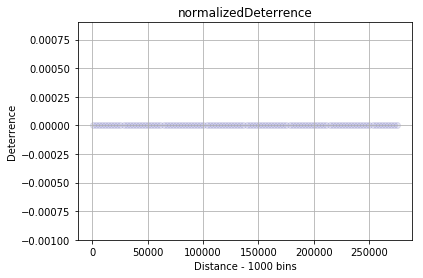

In [213]:
mask = ((Dfn.T[0]/nDfn.T[0])>0.00004)&(bin_edges_d>150000)
plt.scatter(x = bin_edges_d, y = Dfn/nDfn, c='DarkBlue', alpha=0.1)
plt.scatter(x = bin_edges_d[mask], y = Dfn[mask]/nDfn[mask], c='red', alpha=0.1)
plt.title('normalizedDeterrence')
plt.xlabel('Distance - 1000 bins')
plt.ylabel('Deterrence')
#plt.loglog()
plt.ylim(-0.001,0.0009)
plt.grid()

### Graps

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


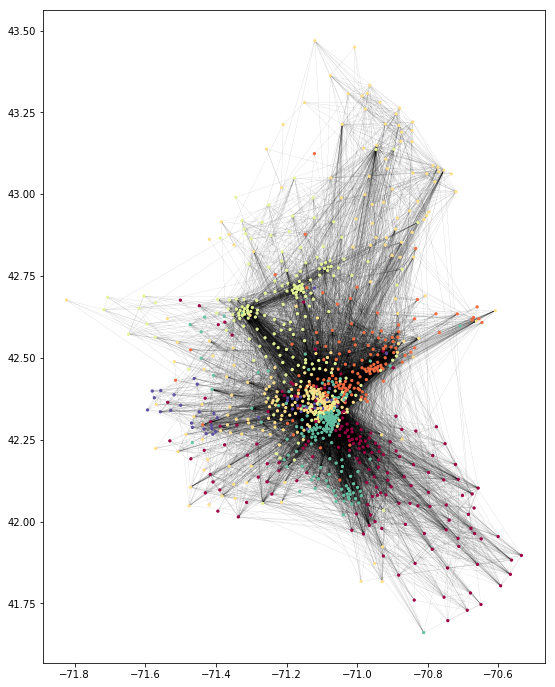

In [214]:
# Mg-vel
plt.figure(figsize=(9,12))
nx.draw_networkx_nodes(g_fol_hh, pos, node_color=S.T[0],cmap='Spectral', node_size=5)
nx.draw_networkx_edges(g_fol_hh, pos, width = 0.05)

In [215]:
np.unique(S, return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([169, 146, 258, 203, 164,  43]))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


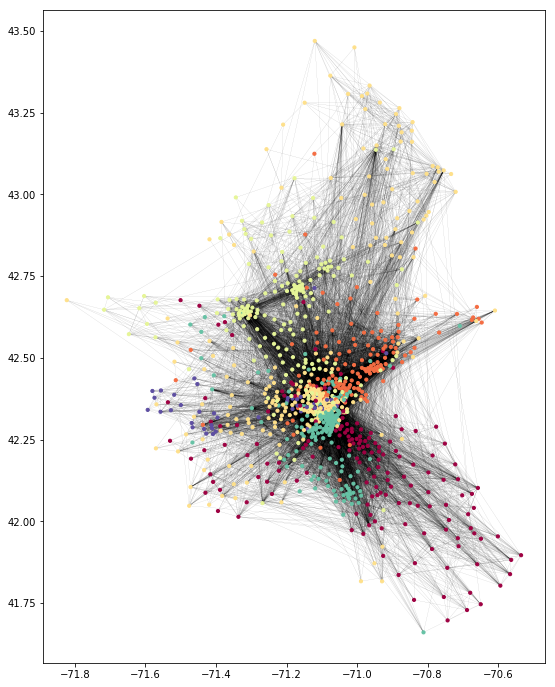

In [216]:
# Ms-sel
plt.figure(figsize=(9,12))
nx.draw_networkx_nodes(g_fol_hh, pos, node_color=S.T[0],cmap='Spectral', node_size=10)
nx.draw_networkx_edges(g_fol_hh, pos, width = 0.05)

In [217]:
unique, count= np.unique(S, return_counts=True)

In [218]:
unique, count

(array([1, 2, 3, 4, 5, 6]), array([169, 146, 258, 203, 164,  43]))

S_mod = np.where(S==(9|16|36|37|38|40|41|42|43|44|45|46|47), 200, S)
S_mod = np.where(S==(9|16|36), 200, S)
S_mod = S
for i in 1:len(unique)
    if count[i-1]<5
     )   S_mod = np.where(S_mod==i, 200, S_mod)
    

In [219]:
S_mod = S
for i in unique:
    if count[int(i-1)]<5:
        S_mod = np.where(S_mod==i, 200, S_mod)

In [220]:
unique_smod, count_smod = np.unique(S_mod, return_counts=True)
unique_smod, count_smod

(array([1, 2, 3, 4, 5, 6]), array([169, 146, 258, 203, 164,  43]))

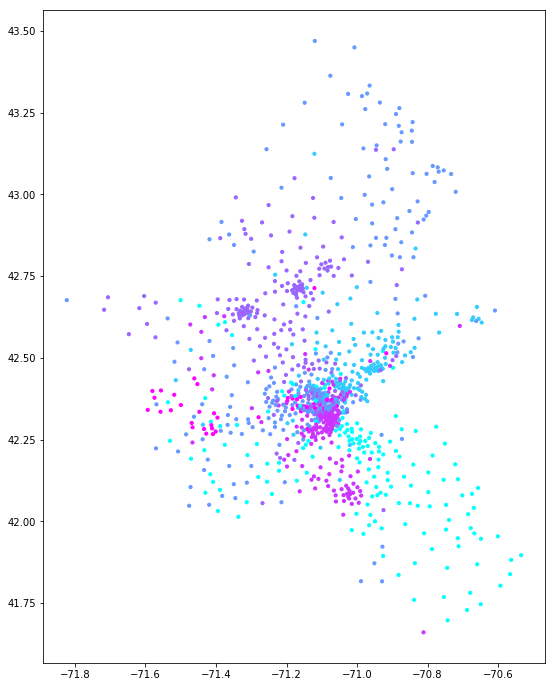

In [221]:
# Ms-sel KICSIK ÁTSZÍNEZVE - N-ek LOGARITMÁLVA
plt.figure(figsize=(9,12))
nx.draw_networkx_nodes(g_fol_hh, pos, node_color=S_mod.T[0],cmap='cool', node_size=10)
# nx.draw_networkx_edges(g_fol_hh, pos, width = 0.05)
plt.show()

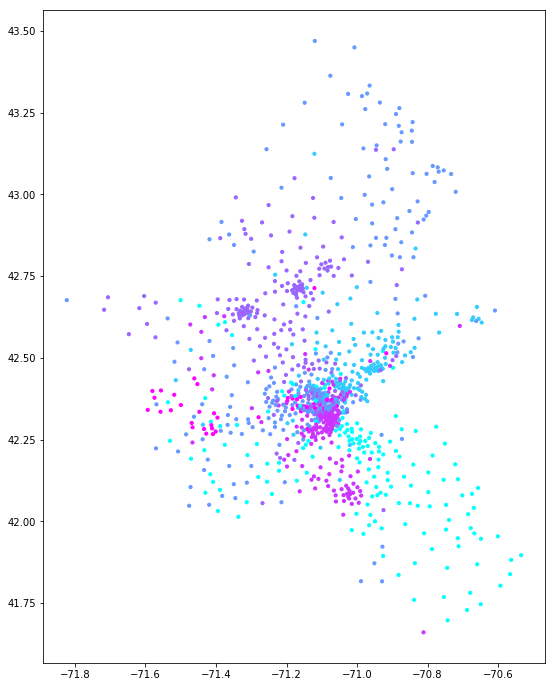

In [222]:
# Ms-sel KICSIK ÁTSZÍNEZVE - N-ek 1-ek
plt.figure(figsize=(9,12))
nx.draw_networkx_nodes(g_fol_hh, pos, node_color=S_mod.T[0],cmap='cool', node_size=10)
# nx.draw_networkx_edges(g_fol_hh, pos, width = 0.05)
plt.show()

### Boxplots

In [223]:
#### ONLY FOR CONSENSUS CLUSTERING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! + 1
S_list = [item for sublist in np.ndarray.tolist(S) for item in sublist] # make a flat list instead of list of lists
# S is the computed partitions

In [224]:
nodelist = list(g_fol_hh.nodes())

In [225]:
boxplot_df = pd.DataFrame(S_list, index = nodelist, columns =['S']) ### KÉRÉDS HIBA?? AZ S-BEN UGYANOLYAN SORRENDBEN VANNAK, MINT AMILYEN SORRENDBEN A GRÁF NODEKJAI VANNAK?

In [226]:
boxplot_df['S'] = (boxplot_df.S.map(lambda p: int(p)))

In [227]:
boxplot_df = pd.merge(boxplot_df, boston_tracts[['geoid','geometry','centroid']], left_index=True, right_on='geoid', how='left')
boxplot_df = boxplot_df.rename(columns={"geometry": "polygon"})

In [228]:
# calculate proportions - mean tract population is not the same among communities (below below)

# for 2012
census['educ_bach_p'] = census['education_bachelor']/census['population']
census['educ_total_p'] = census['education_total']/census['population']
census['white_p'] = census['white']/census['population']
census['black_p'] = census['black']/census['population']
census['native_p'] = census['native']/census['population']
census['asian_p'] = census['asian']/census['population']

# for 2017
census_2 = census_2.rename(columns={'population':'population_2', 'education_bachelor':'education_bachelor_2', 'education_total':'education_total_2', 'income':'income_2','white':'white_2', 'black':'black_2','native':'native_2', 'asian':'asian_2', 'geoid':'geoid_2', 'educ_bach_p':'educ_bach_p_2', 'educ_total_p':'educ_total_p_2','white_p':'white_p_2', 'black_p':'black_p_2','native_p':'native_p_2', 'asian_p':'asian_p_2'})

census_2['educ_bach_p_2'] = census_2['education_bachelor_2']/census_2['population_2']
census_2['educ_total_p_2'] = census_2['education_total_2']/census_2['population_2']
census_2['white_p_2'] = census_2['white_2']/census_2['population_2']
census_2['black_p_2'] = census_2['black_2']/census_2['population_2']
census_2['native_p_2'] = census_2['native_2']/census_2['population_2']
census_2['asian_p_2'] = census_2['asian_2']/census_2['population_2']

In [229]:
boxplot_df = pd.merge(boxplot_df, census[['population', 'education_bachelor', 'education_total', 'income','white', 'black','native', 'asian', 'geoid', 'educ_bach_p', 'educ_total_p','white_p', 'black_p','native_p', 'asian_p']], on='geoid')
boxplot_df = pd.merge(boxplot_df, census_2[['population_2', 'education_bachelor_2', 'education_total_2', 'income_2','white_2', 'black_2','native_2', 'asian_2', 'geoid_2', 'educ_bach_p_2', 'educ_total_p_2','white_p_2', 'black_p_2','native_p_2', 'asian_p_2']], left_on='geoid', right_on='geoid_2')

In [230]:
boxplot_df['growth'] = boxplot_df['income_2'] - boxplot_df['income']

In [477]:
colors_max9 = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'][0:int(max(S))]
mypalette = sns.color_palette(colors_max9)

In [478]:
# mypalette = sns.color_palette(palette = "RdYlGn", n_colors=int(max(S)))
mypalette_2 = dict(zip(range(1,len(mypalette)+1),mypalette)) 

In [479]:
# preparation for sorting by means
boxplot_df_grouped = boxplot_df.groupby('S').mean()

In [480]:
def sorting(df_grouped, by):
    sorted_parts = list(df_grouped.sort_values(by = by, ascending = False).index)
    return sorted_parts

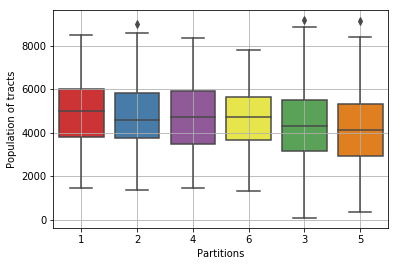

In [481]:
x = "S" # partiton number from 1 to max partition number
y = "population"
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
#plt.title('with raw edge weights')
plt.xlabel('Partitions')
plt.ylabel('Population of tracts')
plt.grid()

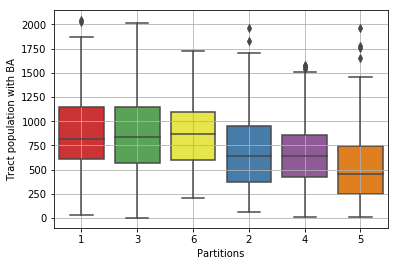

In [482]:
x = "S" # partiton number from 1 to max partition number
y = 'education_bachelor'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Tract population with BA')
plt.grid()

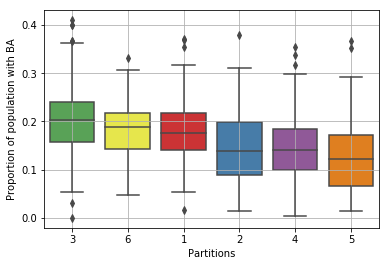

In [483]:
x = "S" # partiton number from 1 to max partition number
y = 'educ_bach_p'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Proportion of population with BA')
plt.grid()

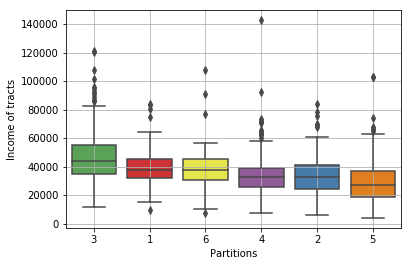

In [484]:
x = "S" # partiton number from 1 to max partition number
y = "income"
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Income of tracts')
plt.grid()

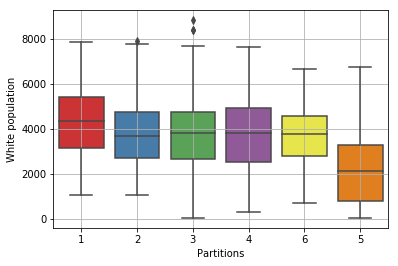

In [485]:
x = "S" # partiton number from 1 to max partition number
y = 'white'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('White population')
plt.grid()

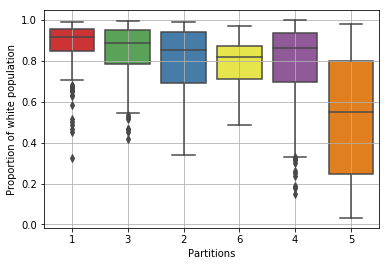

In [486]:
x = "S" # partiton number from 1 to max partition number
y = 'white_p'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Proportion of white population')
plt.grid()

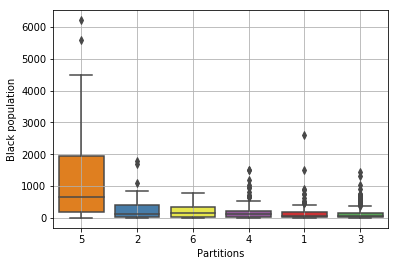

In [487]:
x = "S" # partiton number from 1 to max partition number
y = 'black'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Black population')
plt.grid()

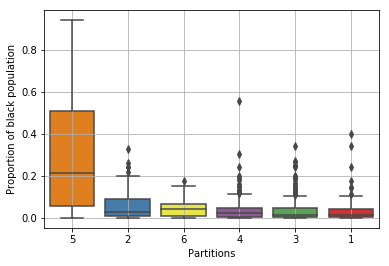

In [488]:
x = "S" # partiton number from 1 to max partition number
y = 'black_p'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Proportion of black population')
plt.grid()

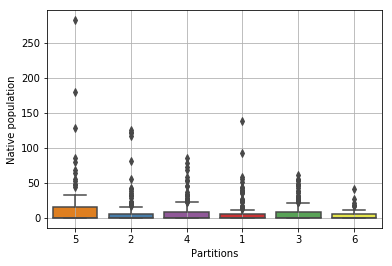

In [489]:
x = "S" # partiton number from 1 to max partition number
y = 'native'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Native population')
plt.grid()

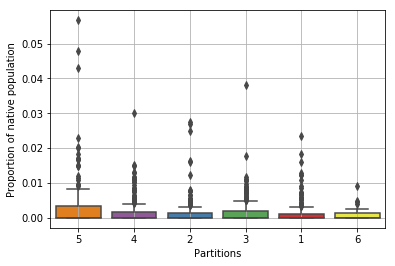

In [490]:
x = "S" # partiton number from 1 to max partition number
y = 'native_p'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Proportion of native population')
plt.grid()

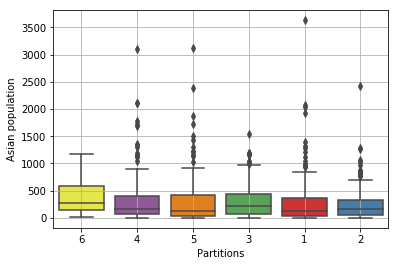

In [491]:
x = "S" # partiton number from 1 to max partition number
y = 'asian'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Asian population')
plt.grid()

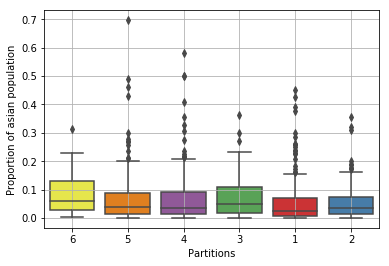

In [492]:
x = "S" # partiton number from 1 to max partition number
y = 'asian_p'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Proportion of asian population')
plt.grid()

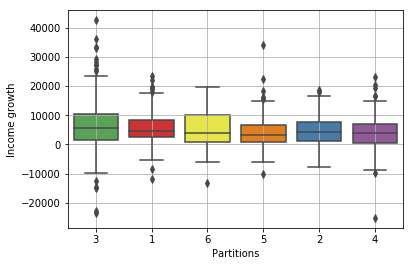

In [493]:
x = "S" # partiton number from 1 to max partition number
y = 'growth'
data = boxplot_df
sorted_parts = sorting(boxplot_df_grouped, y)

sns.boxplot(x=x, y=y, data=data, palette = mypalette_2, order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Income growth')
plt.grid()

### Maps

In [494]:
boston_tracts = boston_tracts.merge(boxplot_df, on='geoid')

In [495]:
boston_tracts['color'] = boston_tracts['S'].map(mypalette_2)

KeyError: 'S'

/home/ubuntu/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


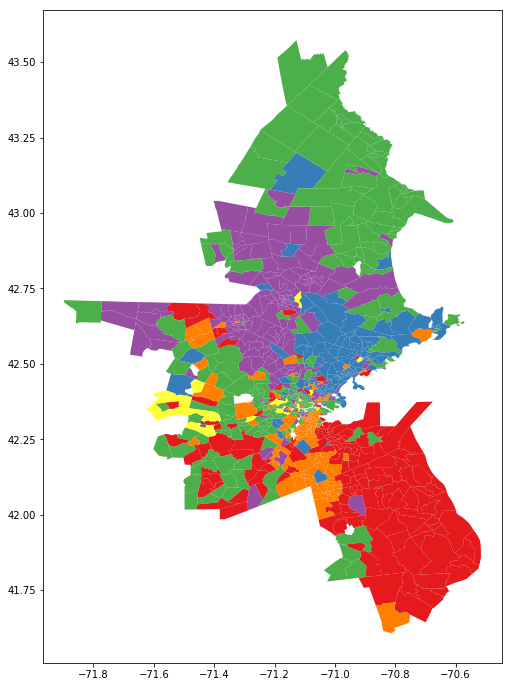

In [496]:
# Communities in the home-home network
# cmap2 = cm.get_cmap('gist_ncar', int(max(S)))
boston_tracts.plot(column='S', color=boston_tracts['color'], legend=True, figsize=(12,12))
# plt.title('Modified edge weights', size=20)
# savefig('community_map_mod', dpi=1200, bbox_inches='tight')

### Barplots

In [497]:
user_dict = dict(zip(g_fol_hh.nodes(), [tract_outdeg_mob.loc[k].iloc[0] for k in g_fol_hh.nodes()])) 

In [498]:
boxplot_df['users'] = boxplot_df['geoid'].map(user_dict)
boxplot_df['tracts'] = 1 # groupby('S') sum adds up the number of tracts in each community

In [499]:
community_sum_df = (boxplot_df.groupby('S').sum()).reset_index()

In [500]:
boxplot_df.groupby('S').std()

,population,education_bachelor,education_total,income,white,black,native,asian,educ_bach_p,educ_total_p,...,asian_2,educ_bach_p_2,educ_total_p_2,white_p_2,black_p_2,native_p_2,asian_p_2,growth,users,tracts
S,,,,,,,,,,,,,,,,,,,,,
1,1583.663956,391.184798,1114.431726,11778.781004,1563.134617,277.177076,17.367029,461.718198,0.060452,0.074575,...,533.884532,0.063726,0.082969,0.128017,0.052754,0.003155,0.099086,5715.600861,20.121895,0.0
2,1570.987466,419.708573,1176.643808,13930.422447,1633.389213,304.583109,22.559121,323.282901,0.070135,0.094929,...,339.707942,0.071048,0.091810,0.206785,0.070495,0.005334,0.062706,5339.789877,16.655639,0.0
3,1656.073432,383.260307,1126.476386,17889.236378,1599.227091,212.451085,11.763165,292.192245,0.066127,0.099995,...,373.535471,0.068856,0.099139,0.124727,0.055982,0.002693,0.071536,8548.708749,17.280604,0.0
4,1549.546846,358.747575,1154.376034,15376.710752,1680.931887,241.857282,15.025604,431.711060,0.064752,0.087393,...,485.175953,0.069306,0.086147,0.170107,0.057599,0.007051,0.098159,5611.057176,17.186452,0.0
5,1665.707356,387.756587,1149.918257,15877.754984,1607.918333,1255.827531,31.065720,456.065180,0.069293,0.084034,...,441.059325,0.066206,0.076327,0.274120,0.257802,0.008999,0.091048,5418.065556,12.567917,0.0
6,1546.194496,364.627123,1265.708619,18407.551908,1385.926019,200.846084,8.859491,329.672153,0.057678,0.137140,...,458.804540,0.059942,0.129687,0.128984,0.040081,0.004923,0.086091,6866.440963,35.632522,0.0


Text(0.5, 1.0, 'Number of tracts by community')

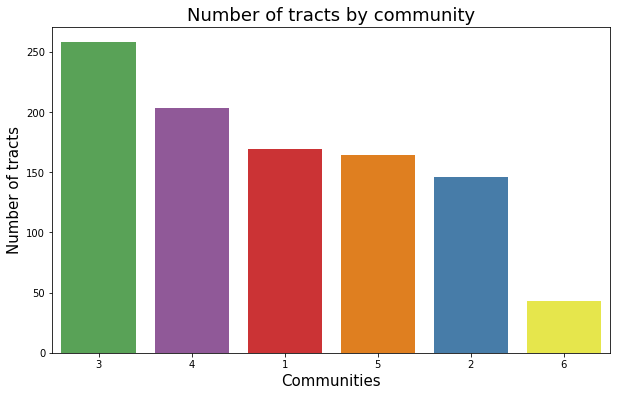

In [501]:
# TRACTS - Number of tracts in each community
plt.figure(figsize=(10,6))
# make barplot and sort bars
sns.barplot(x = 'S',
            y = 'tracts', 
            data = community_sum_df,
            order = community_sum_df.sort_values('tracts', ascending = False).S,
            palette = mypalette_2)

#Threshold line for 80%
#threshold = 0
#summ = 0
#while (community_sum_df.tracts.sum() * 0.80 > summ):
    #summ = summ + community_sum_df.sort_values('tracts', ascending = False).tracts[threshold]
    #threshold = threshold + 1   
#plt.axvline(x=threshold - 0.5, color = 'black')
            
# set labels
plt.xlabel('Communities', size=15)
plt.ylabel('Number of tracts', size=15)
plt.title('Number of tracts by community', size=18)
#plt.savefig('NEV.png', dpi=100)

Text(0.5, 1.0, 'Total population by community')

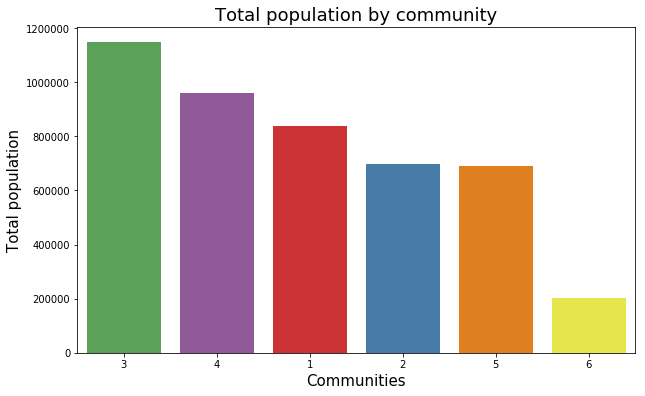

In [502]:
# POPULATION- Total population of each community

plt.figure(figsize=(10,6))
# make barplot and sort bars
sns.barplot(x = 'S',
            y = 'population', 
            data = community_sum_df,
            order = community_sum_df.sort_values('population', ascending = False).S,
            palette = mypalette_2)

#Threshold line for 80%
#threshold = 0
#summ = 0
#while (community_sum_df.population.sum() * 0.5 > summ):
    #summ = summ + community_sum_df.sort_values('population', ascending = False).population[threshold]
    #threshold = threshold + 1
#plt.axvline(x=threshold - 0.5, color = 'black')

            
# set labels
plt.xlabel('Communities', size=15)
plt.ylabel('Total population', size=15)
plt.title('Total population by community', size=18)
#plt.savefig('NEV.png', dpi=100)

Text(0.5, 1.0, 'Total number of users by community')

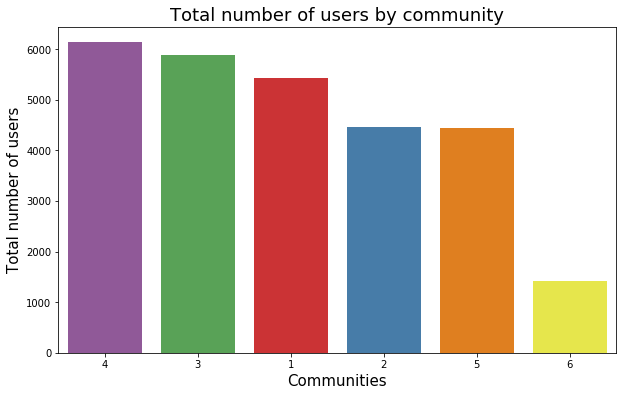

In [503]:
# USERS - Total number of observed users in each community

plt.figure(figsize=(10,6))
# make barplot and sort bars
sns.barplot(x = 'S',
            y = 'users', 
            data = community_sum_df,
            order = community_sum_df.sort_values('users', ascending = False).S,
            palette = mypalette_2)

#Threshold line for 80%
#threshold = 0
#summ = 0
#while (community_sum_df.users.sum() * 0.5 > summ):
    #summ = summ + community_sum_df.sort_values('users', ascending = False).users[threshold]
    #threshold = threshold + 1
#plt.axvline(x=threshold - 0.5, color = 'black')
            
# set labels
plt.xlabel('Communities', size=15)
plt.ylabel('Total number of users', size=15)
plt.title('Total number of users by community', size=18)
#plt.savefig('NEV.png', dpi=100)

In [504]:
# Standard devion of distance between centroids within the same community

# 1. From distance matrix filter the rows and columns for a given community --> only distances within community remains
# 2. create an array from the matrix: try: A = np.squeeze(np.asarray(M))
# 3. drop zeros from the array (these are not actual within distances)
try:
X = np.random.randn(1e3, 5)
X[np.abs(X)< .1]= 0 # some zeros
X = np.ma.masked_equal(X,0)
plt.boxplot(X) #masked values are not plotted

#other functionalities of masked arrays
X.compressed() # get normal array with masked values removed
X.mask # get a boolean array of the mask
X.mean() # it automatically discards masked values


# 4. calculate standard deviation on the array

IndentationError: expected an indented block (<ipython-input-504-f1b90c6ca761>, line 7)

In [505]:
# standard deviation of distances within community
STD = []
com_list = community_sum_df.S
for i in com_list: # for every community
    M = (D[S.T[0]==i].T)[S.T[0]==i] # within community distance matrix
    half = int(len(M)/2)
    STD.append(M[:half][M[:half]!=0].std())

In [506]:
community_sum_df['std'] = STD

Text(0.5, 1.0, 'Standard deviation of within distances by community')

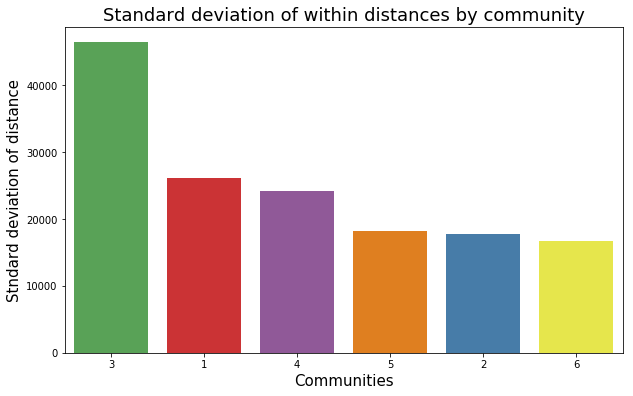

In [507]:
# USERS - Total number of observed users in each community

plt.figure(figsize=(10,6))
# make barplot and sort bars
sns.barplot(x = 'S',
            y = 'std', 
            data = community_sum_df,
            order = community_sum_df.sort_values('std', ascending = False).S,
            palette = mypalette_2)
            
# set labels
plt.xlabel('Communities', size=15)
plt.ylabel('Stndard deviation of distance', size=15) # standard deviation of distances between centroids of tract of the community
plt.title('Standard deviation of within distances by community', size=18)
#plt.savefig('NEV.png', dpi=100)

#### Moment of inertia
dist^2*mass_of_point

MY VERSION (dist^2*population)/total population - I decided to divide by total population to normalize

In [508]:
# Center of gravity for each community
cg = {}
for i in com_list: # for every community
    com_data = boxplot_df[boxplot_df.S==i]
    m = com_data.population
    x = com_data.centroid.map(lambda p: p.coords[0][0])
    y = com_data.centroid.map(lambda p: p.coords[0][1])
    cgx = np.sum(x*m)/np.sum(m)
    cgy = np.sum(y*m)/np.sum(m)
    cg[i] = (cgx,cgy)

In [509]:
# Center of gravity for each community
com_dist_c = {} # for each community distances of its tracts from cg(=center)
for com in com_list: # for every community
    com_data = boxplot_df[boxplot_df.S==com]
    centroids = com_data.centroid
    dist_l = []
    for tract in centroids:
        dist_l.append(math.dist(tract,cg[com]) ## KERDES, hogy lehet jobban ket pont tavolsagat szamolni
    com_dist_c[com] = dist_l

                      
                      
EZ HIBAS

SyntaxError: invalid syntax (<ipython-input-509-2e674c55e2ac>, line 9)

In [511]:
### középponttól mért távolságra kell
kozeppont communitynkent
D kozepponttol mert --> matrix
lentebbi!!!
majd szures communityre


D_2 = np.power(D, 2) # square element-wise 
pop_sort =np.array([boxplot_df.set_index('geoid').loc[k].population for k in g_fol_hh.nodes()])
inert = D_2*pop_sort

SyntaxError: invalid syntax (<ipython-input-511-62925b9aebfc>, line 2)

### Simga convergence - income

In [512]:
community_std_df = (boxplot_df.groupby('S').std()).reset_index()

In [513]:
community_std_df['income_conv'] = community_std_df['income'] - community_std_df['income_2']

Text(0.5, 1.0, 'Income convergence within communities')

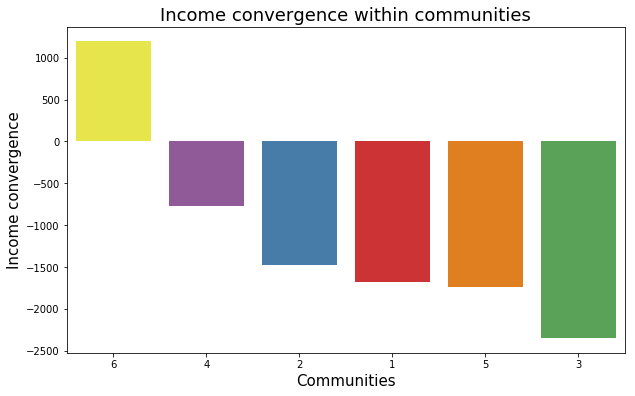

In [514]:
# USERS - Total number of observed users in each community

plt.figure(figsize=(10,6))
# make barplot and sort bars
sns.barplot(x = 'S',
            y = 'income_conv', 
            data = community_std_df,
            order = community_std_df.sort_values('income_conv', ascending = False).S,
            palette = mypalette_2)
            
# set labels
plt.xlabel('Communities', size=15)
plt.ylabel('Income convergence', size=15) # standard deviation of distances between centroids of tract of the community
plt.title('Income convergence within communities', size=18)
#plt.savefig('NEV.png', dpi=100)

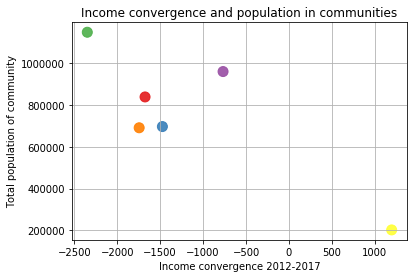

In [515]:
# convergence - size(population) of community scatterplot
plt.scatter(community_std_df.income_conv, community_sum_df.population, color = mypalette, marker='o', s=100, alpha=0.9);
plt.title('Income convergence and population in communities')
plt.xlabel('Income convergence 2012-2017')
plt.ylabel('Total population of community')
plt.grid()

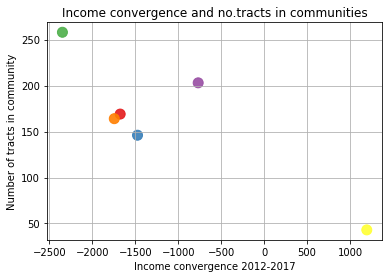

In [516]:
# convergence - size(number of tracts) of community scatterplot
plt.scatter(community_std_df.income_conv, community_sum_df.tracts, color = mypalette, marker='o', s=100, alpha=0.9);
plt.title('Income convergence and no.tracts in communities')
plt.xlabel('Income convergence 2012-2017')
plt.ylabel('Number of tracts in community')
plt.grid()

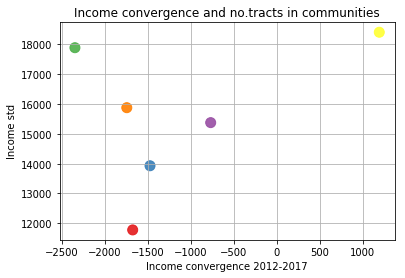

In [517]:
# convergence - size(number of tracts) of community scatterplot
plt.scatter(community_std_df.income_conv, community_std_df.income, color = mypalette, marker='o', s=100, alpha=0.9);
plt.title('Income convergence and no.tracts in communities')
plt.xlabel('Income convergence 2012-2017')
plt.ylabel('Income std')
plt.grid()

### Density for income per community

In [518]:
income_df = boxplot_df[['S','income','income_2']].set_index('S')
income_df = income_df.rename(columns={"income": "2012", "income_2": "2017"})

In [519]:
income_df = income_df.unstack().reset_index()

In [520]:
income_df = income_df.rename(columns={"level_0": "year", 0: "income"})

In [521]:
0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2)]income_df.head()

,year,S,income
0,2012,1,33726.0
1,2012,1,28844.0
2,2012,2,16884.0
3,2012,3,38047.0
4,2012,2,19354.0


In [522]:
# preparation for sorting by means
income_df_grouped = income_df.groupby('S').mean()

In [523]:
income_df.year.max()

'2017'

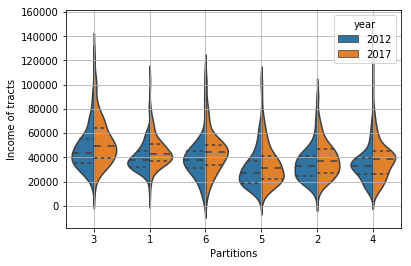

In [524]:
x = "S" # partiton number from 1 to max partition number
y = "income"
data = income_df
#sorted_parts = sorting(income_df_grouped, y)

sns.violinplot(x=x, y=y, hue= 'year', data=data, split=True, scale="count", inner="quartile", order = sorted_parts)
plt.xlabel('Partitions')
plt.ylabel('Income of tracts')
plt.grid()

Text(0, 0.5, 'Density')

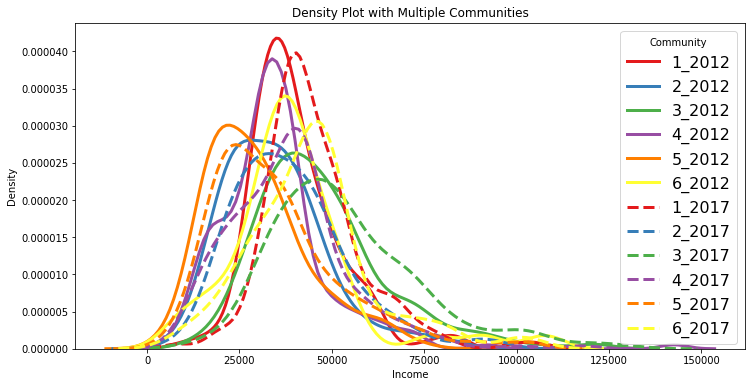

In [538]:
# Income distribution  plot

f = plt.figure(figsize=(12,6))

#2012
df = income_df[income_df.year == '2012']
# Iterate through the communities
for c in range(1,S.max()+1):
    # Subset to the communities
    subset = df[df['S'] == c]
    color = mypalette[c-1]

    # Draw the density plot
    sns.distplot(subset['income'], hist = False, kde = True,
             kde_kws = {'linewidth': 3, 'color': color},
             label = str(c) + "_"+ '2012')

#2017
df = income_df[income_df.year == '2017']
# Iterate through the communities
for c in range(1,S.max()+1):
    # Subset to the communities
    subset = df[df['S'] == c]
    color = mypalette[c-1]

    # Draw the density plot
    sns.distplot(subset['income'], hist = False, kde = True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color': color},
             label = str(c) + "_"+ '2017')
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Community')
plt.title('Density Plot with Multiple Communities')
plt.xlabel('Income')
plt.ylabel('Density')

### Convergence - based on Drennan and Lobo (1999) A simple test for convergence of metropolitan income in the united states

In [586]:
# 1 below average, 2 above average
# A_1 = inc=0 / A_2 = inc=1
# B_1 = gro=0 / B_2 = gro=1

In [587]:
# filtering - choose a dataframe on which we will calculate convergence
conv_df = boxplot_df

In [602]:
def conv(conv_df):
    # categorizing tract based on whether their income and incomegrowth is above average
    n = len(conv_df)
    inc_avg = sum(conv_df.income) / len(conv_df.income)
    gro_avg = sum(conv_df.growth) / len(conv_df.growth)


    conv_df['inc'] = conv_df.income.map(lambda i: i>inc_avg).astype(int) ### KERDES: MIÉERT KÍVÜLRE KELL AZ ASTYPE???
    conv_df['gro'] = conv_df.growth.map(lambda i: i>gro_avg).astype(int)

    # initial income below average, income growth below average
    i_0 = len(conv_df[conv_df.inc==0])
    i_1 = len(conv_df[conv_df.inc==1])
    g_0 = len(conv_df[conv_df.gro==0])
    g_1 = len(conv_df[conv_df.gro==1])
    i_0_g_0 = len(conv_df[conv_df.inc==0][conv_df.gro==0])
    i_1_g_0 = len(conv_df[conv_df.inc==1][conv_df.gro==0])
    i_0_g_1 = len(conv_df[conv_df.inc==0][conv_df.gro==1])
    i_1_g_1 = len(conv_df[conv_df.inc==1][conv_df.gro==1])

    # check: sum should be number of tracts
    #i_0_g_0 + i_1_g_0 + i_0_g_1 + i_1_g_1


    # conditional probabilities -  a számlálót és a nevezőt is leoszthattuk volna a tractek számával, és akkor probabilitykből lett volna számolva
    p_g0_if_i0 = i_0_g_0 / i_0
    p_g0_if_i1 = i_1_g_0 / i_1
    p_g1_if_i0 = i_0_g_1 / i_0
    p_g1_if_i1 = i_1_g_1 / i_1

    # pi in the paper PI!!!!
    p_g0 = g_0 / n
    p_g1 = g_1 / n

    # standard error
    std_g0 = ((p_g0*(1-p_g0))/n)**0.5
    std_g1 = ((p_g1*(1-p_g1))/n)**0.5

    z_g0_i0 = (p_g0_if_i0 - p_g0) / std_g0
    z_g0_i1 = (p_g0_if_i1 - p_g0) / std_g0
    z_g1_i0 = (p_g1_if_i0 - p_g1) / std_g1
    z_g1_i1 = (p_g1_if_i1 - p_g1) / std_g1
    
    return(z_g0_i0,z_g1_i1,z_g0_i1,z_g1_i0)

In [603]:
conv(conv_df)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(3.3060912395305957,
 4.543879022446642,
 -4.543879022446642,
 -3.3060912395305957)

In [608]:
conv(boxplot_df[boxplot_df.S == 1])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_

(0.7866445292185079,
 1.1975782385117582,
 -1.1975782385117582,
 -0.7866445292185079)

In [609]:
conv(boxplot_df[boxplot_df.S == 2])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_

(1.3837171154895405,
 1.5872049265909454,
 -1.5872049265909454,
 -1.3837171154895405)

In [610]:
conv(boxplot_df[boxplot_df.S == 3])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_

(0.583370199043873,
 0.7974510060324496,
 -0.7974510060324496,
 -0.5833701990438712)

In [611]:
conv(boxplot_df[boxplot_df.S == 4])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_

(1.8833356273381237,
 2.4123624889499564,
 -2.4123624889499564,
 -1.8833356273381252)

In [612]:
conv(boxplot_df[boxplot_df.S == 5])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_

(2.004120060195477, 2.9758146348357064, -2.97581463483571, -2.0041200601954765)

In [613]:
conv(boxplot_df[boxplot_df.S == 6])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_

(-1.0819221578078326, -1.654704476647273, 1.654704476647273, 1.081922157807832)